# Code to analyse difference sensation levels at 65 dB with signal at BCD side (90 degrees)

27-12-2020 Guido Cattani, Revision 12-06-2022

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import mannwhitneyu as mannwhitneyu
from scipy.stats import shapiro as shapiro
from scipy.stats import ttest_ind as ttest_ind
from scipy.stats import levene as levene

In [2]:
# read difference sensation levels BC - AC simulated with a 65 dB ISDS input signal at BCD side (90 degree angle)
def read_diff_sl():
    f_in = '/media/guido/LACIE/Cingle_Guido/Master/Headband/Diff_SL.xlsx'
    p_in = Path(f_in)   
    df = pd.read_excel(p_in, engine='openpyxl', sheet_name='Diff_SL_65dB_90deg', header=0, nrows=85)
    df = df.drop(['Unnamed: 0'], axis=1)
    df = df.fillna(pd.NA)
    return df

In [3]:
# adjust column names, change format columns labels 'f_Hz' to f

data = read_diff_sl()
clmns = data.columns
l = list()
for clm in clmns:
    l.append(clm)
l = l[2:]
l2 = list()
for s in l:
    s = s.rstrip('_Hz')
    f = int(s)
    l2.append(f)
d = dict()
d1 = dict()
for i in range(len(l)):
    d.update({l[i] : l2[i]})
    d1.update({l2[i] : l[i]})

data1 = data.drop(columns='Study_ID') # drop first column
data1 = data1.rename(columns=d)
data1 = data1.dropna(axis='index')
type_device = data1.pop('Device')
data1 = data1.astype('int64')
data1.insert(0, 'Device', type_device)

In [4]:
data1

,Device,125,160,200,250,315,400,500,630,800,1000,1250,1600,2000,2500,3150,4000,5000,6300,8000
0,BP110,-23,-40,-51,-55,-47,-42,-36,-26,-18,-18,-23,-29,-28,-31,-25,-32,-16,0,-14
1,BP110,-29,-46,-56,-60,-54,-50,-41,-27,-16,-12,1,7,-4,-5,6,-6,0,3,-21
5,BP110,-19,-38,-50,-55,-46,-40,-33,-21,-11,-8,-8,-9,-10,-7,5,-4,14,30,19
9,BP110,-22,-39,-49,-53,-42,-35,-26,-13,-3,0,1,-1,-16,-16,-8,-15,0,13,-1
11,BP110,-37,-54,-65,-69,-52,-40,-26,-18,-9,-10,-13,-18,-21,-22,-15,-25,-15,-8,-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,BAHA5P,-42,-57,-66,-68,-72,-66,-57,-36,-20,-7,-11,-17,-9,-6,7,-9,0,5,-19
81,BAHA5P,-26,-39,-48,-48,-50,-47,-38,-24,-14,-9,-7,-6,-3,-6,-2,-16,-9,-3,-28
82,BAHA5P,-26,-44,-54,-58,-57,-53,-40,-30,-23,-22,-4,6,4,-6,-7,-24,-12,-4,-25
83,BAHA5P,-37,-50,-58,-58,-55,-44,-31,-16,-1,6,3,-4,-10,-13,-3,2,15,26,7


In [5]:
# group data by device type and perform calculation of quantiles 10, 50, 90
dvc = data1.groupby('Device')
quantiles = [0.10, 0.50, 0.90]
q = dvc.quantile(q=quantiles)

# convert Pandas object in numpy array
frqc = np. array(l2 , dtype=int)
p10_bh5 = q.iloc[0].T.to_numpy()
median_bh5 = q.iloc[1].T.to_numpy()
p90_bh5 = q.iloc[2].T.to_numpy()
p10_bp110 = q.iloc[3].T.to_numpy()
median_bp110 = q.iloc[4].T.to_numpy()
p90_bp110 = q.iloc[5].T.to_numpy()

# select BP110 data and convert the Pandas Dataframe to numpy array
is_bp110 =  data1['Device']=='BP110'
output_bp110 = data1[is_bp110]
dvc1 = output_bp110.pop('Device')
bp110 = output_bp110.T.to_numpy()

# select BAHA5P data and convert the Pandas Dataframe to numpy array
is_baha5p =  data1['Device']=='BAHA5P'
output_baha5p = data1[is_baha5p]
dvc2 = output_baha5p.pop('Device')
bh5 = output_baha5p.T.to_numpy()

In [6]:
len(output_bp110)

35

In [7]:
len(output_baha5p)

35

In [8]:
# select data columns for violin plot with frequency 1 - 8 kHz  and convert data to numpy arrays

output_bp110_hf = output_bp110.drop(columns =[125, 160, 200, 250, 315, 400, 500, 630, 800]) 
output_baha5p_hf = output_baha5p.drop(columns =[125, 160, 200, 250, 315, 400, 500, 630, 800]) 
bp110_hf = output_bp110_hf.to_numpy()
bh5_hf = output_baha5p_hf.to_numpy()

In [9]:
# check normality output group BAHA5P & BP110 with Shapiro-Wilk test

shp = dict()

for i in range(0, 19):
    a = output_baha5p.iloc[:, i]
    b = output_bp110.iloc[:, i]
    f = l2[i]
    shapiro_stat_bh5, pVal_bh5 = shapiro(a) # bh5 scipy.stats Shapiro-Wilk test test
    shapiro_stat_bp110, pVal_bp110 = shapiro(b) # bp110 scipy.stats Shapiro-Wilk test test
    bh5_is_normal = False if pVal_bh5 < 0.05 else True
    bp110_is_normal = False if pVal_bp110 < 0.05 else True
    both_is_normal = True if bh5_is_normal and bp110_is_normal else False
    st = {f: [shapiro_stat_bh5, pVal_bh5, bh5_is_normal, shapiro_stat_bp110, pVal_bp110, bp110_is_normal, both_is_normal]}
    shp.update(st)

shapiro_test = pd.DataFrame.from_dict(shp)
dish =  {0: 'Shapiro test statistic BH5', 1: 'p-value BH5', 2: 'normally distributed in BH5', 3: 'Shapiro test statistic BP110', 
         4: 'p-value BP110', 5: 'normally distributed in BP110', 6: 'normally distributed in both groups'}
shapiro_test = shapiro_test.rename(index=dish)
shapiro_test

,125,160,200,250,315,400,500,630,800,1000,1250,1600,2000,2500,3150,4000,5000,6300,8000
Shapiro test statistic BH5,0.948453,0.95355,0.957147,0.966358,0.96888,0.972204,0.974767,0.980352,0.971441,0.956201,0.973676,0.982735,0.97566,0.960617,0.983226,0.959851,0.948213,0.941697,0.94429
p-value BH5,0.10157,0.145641,0.187513,0.351256,0.413222,0.506592,0.586468,0.770581,0.484039,0.175505,0.551771,0.843892,0.61551,0.238598,0.85789,0.226322,0.099859,0.063038,0.075676
normally distributed in BH5,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
Shapiro test statistic BP110,0.966518,0.969009,0.970311,0.962617,0.964612,0.961089,0.964196,0.97615,0.986595,0.983869,0.958355,0.92841,0.973724,0.964739,0.96651,0.967164,0.980379,0.971778,0.972375
p-value BP110,0.354952,0.416601,0.451836,0.273578,0.312941,0.246462,0.304358,0.631626,0.938081,0.875431,0.204014,0.025097,0.553277,0.315595,0.354764,0.370211,0.771431,0.49394,0.511729
normally distributed in BP110,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True
normally distributed in both groups,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True


In [10]:
# compare distribution output BAHA5P vs. BP110 with t-test

tti = dict()

for i in range(0, 19):
    a = output_baha5p.iloc[:, i]
    b = output_bp110.iloc[:, i]
    f = l2[i]
    # Levene test for equal variances
    variance_test = levene(a, b)
    # scipy.stats ttest_ind, if variance is not equivalent Welch’s t-test will be performed
    if variance_test[1] < 0.05: ttest_statistic, pVal = ttest_ind(a , b, equal_var=False, alternative='two-sided') 
    else: ttest_statistic, pVal = ttest_ind(a , b, equal_var=True, alternative='two-sided') 
    st = {f: [ttest_statistic, pVal]}
    tti.update(st)
t_test = pd.DataFrame.from_dict(tti, dtype='float')
ditt =  {0: '(Welch’s t-test) ind. statistic', 1: 'p-value (two-sided) (Welch’s) t-test ind.'}
t_test = t_test.rename(index=ditt)

both_norm = shapiro_test.loc['normally distributed in both groups']
t_test = t_test * both_norm
t_test.mask(t_test == 0, pd.NA, inplace=True)
t_test

,125,160,200,250,315,400,500,630,800,1000,1250,1600,2000,2500,3150,4000,5000,6300,8000
(Welch’s t-test) ind. statistic,-4.274491,-4.142644,-3.917582,-3.344314,-7.135669,-6.866018,-4.034364,-4.409339,-5.065821,-3.738645,-0.272212,<NA>,2.724704,3.463433,2.897495,2.735126,1.578378,0.71549,-0.38908
p-value (two-sided) (Welch’s) t-test ind.,0.000061,0.000097,0.00021,0.001345,0.0,0.0,0.000141,0.000038,0.000003,0.000382,0.786284,<NA>,0.008174,0.000927,0.005057,0.007945,0.11912,0.476756,0.698432


In [11]:
# compare distribution output BAHA5P vs. BP110 with Mann Whitney U test

mwu = dict()

for i in range(0, 19):
    a = output_baha5p.iloc[:, i]
    b = output_bp110.iloc[:, i]
    f = l2[i]
    # scipy.stats mannwhitneyu test
    u_statistic, pVal = mannwhitneyu(a , b, use_continuity=False, alternative='two-sided') 
    pVal = round(pVal, 15)
    st = {f: [u_statistic, pVal]}
    mwu.update(st)
u_test = pd.DataFrame.from_dict(mwu, dtype='float')

In [12]:
# join percentiles & U-test & t-test and present results in table

q= q.round(decimals=0)
q = q.reset_index()
diq = {0:'BAHA5P P10', 1:'BAHA5P P50', 2:'BAHA5P P90', 
      3:'BP110 P10', 4:'BP110 P50', 5:'BP110 P90'} 

q = q.rename(index=diq)
q = q.drop(['Device', 'level_1'], axis=1)

diu =  {0: 'Mann-Whitney U statistic', 1: 'p-value (two-sided) Mann-Whitney U'}
u_test = u_test.rename(index=diu)
u_test

analysis_output = pd.concat([q, u_test, t_test])

analysis_output = analysis_output.rename(columns=d1)

# write to xlsx file
analysis_output.to_excel("/media/guido/LACIE/Cingle_Guido/Project_band/Analysis_results/analysis_sl_S65dB_BCDside.xlsx",
                         sheet_name='Output_BAHA5_vs_BP110')  

analysis_output

,125_Hz,160_Hz,200_Hz,250_Hz,315_Hz,400_Hz,500_Hz,630_Hz,800_Hz,1000_Hz,1250_Hz,1600_Hz,2000_Hz,2500_Hz,3150_Hz,4000_Hz,5000_Hz,6300_Hz,8000_Hz
BAHA5P P10,-42.0,-58.0,-68.0,-72.0,-70.0,-63.0,-48.0,-36.0,-25.0,-23.0,-15.0,-10.0,-15.0,-16.0,-9.0,-20.0,-9.0,-4.0,-30.0
BAHA5P P50,-34.0,-49.0,-59.0,-62.0,-59.0,-53.0,-39.0,-27.0,-17.0,-13.0,-5.0,-4.0,-5.0,-8.0,-1.0,-9.0,1.0,11.0,-8.0
BAHA5P P90,-26.0,-40.0,-50.0,-50.0,-50.0,-44.0,-28.0,-17.0,-11.0,-6.0,1.0,3.0,4.0,0.0,11.0,9.0,18.0,28.0,9.0
BP110 P10,-37.0,-52.0,-61.0,-65.0,-55.0,-50.0,-42.0,-29.0,-19.0,-18.0,-17.0,-22.0,-21.0,-21.0,-15.0,-30.0,-16.0,-7.0,-27.0
BP110 P50,-28.0,-42.0,-51.0,-54.0,-46.0,-38.0,-27.0,-18.0,-7.0,-6.0,-6.0,-6.0,-12.0,-14.0,-7.0,-13.0,1.0,12.0,-7.0
BP110 P90,-13.0,-29.0,-39.0,-42.0,-32.0,-25.0,-16.0,-8.0,1.0,4.0,4.0,5.0,1.0,-5.0,6.0,-3.0,15.0,30.0,24.0
Mann-Whitney U statistic,304.0,312.5,320.0,358.5,134.5,141.5,302.0,285.5,235.0,299.5,564.0,704.5,828.5,875.5,856.0,821.0,717.5,646.0,578.5
p-value (two-sided) Mann-Whitney U,0.000285,0.000417,0.000581,0.002816,0.0,0.0,0.000262,0.000121,0.000009,0.000233,0.568329,0.279348,0.011095,0.001974,0.004171,0.014228,0.21699,0.693774,0.689442
(Welch’s t-test) ind. statistic,-4.274491,-4.142644,-3.917582,-3.344314,-7.135669,-6.866018,-4.034364,-4.409339,-5.065821,-3.738645,-0.272212,<NA>,2.724704,3.463433,2.897495,2.735126,1.578378,0.71549,-0.38908
p-value (two-sided) (Welch’s) t-test ind.,0.000061,0.000097,0.00021,0.001345,0.0,0.0,0.000141,0.000038,0.000003,0.000382,0.786284,<NA>,0.008174,0.000927,0.005057,0.007945,0.11912,0.476756,0.698432


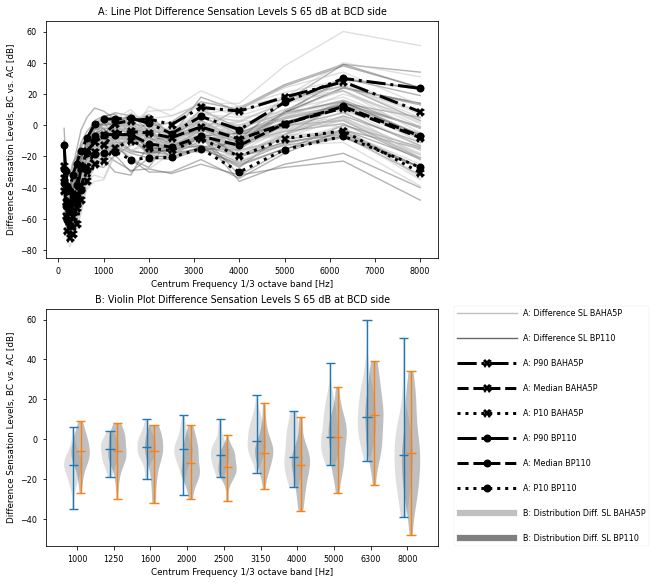

In [13]:
# make a figure to plot output baha5 vs. BP110

plt.style.use('seaborn-paper')
plt.rcParams['axes.facecolor'] = 'white'

fig, (ax, ax1) = plt.subplots(2, constrained_layout=True)

fig.set_figheight(8)
fig.set_figwidth(9)


# make the line plot

ax.set(xlabel='Centrum Frequency 1/3 octave band [Hz]', ylabel='Difference Sensation Levels, BC vs. AC [dB]',
       title='A: Line Plot Difference Sensation Levels S 65 dB at BCD side')

# plot lines based on numpy arrays
ax.plot(frqc, bp110, color="dimgrey", alpha=0.5, label='Output FL BP110')
ax.plot(frqc, bh5, color="silver", alpha=0.5, label='Output FL BAHA5P')
ax.plot(frqc, median_bp110, color='black', marker='o', linestyle='dashed', linewidth=3, markersize=8)
ax.plot(frqc, p10_bp110, color='black', marker='o', linestyle='dotted', linewidth=3, markersize=8)
ax.plot(frqc, p90_bp110, color='black', marker='o', linestyle='dashdot', linewidth=3, markersize=8)
ax.plot(frqc, median_bh5, color='black', marker='X', linestyle='dashed', linewidth=3, markersize=9)
ax.plot(frqc, p10_bh5, color='black', marker='X', linestyle='dotted', linewidth=3, markersize=9)
ax.plot(frqc, p90_bh5, color='black', marker='X', linestyle='dashdot', linewidth=3, markersize=9)


# make the violin plot

xi = list(range(1, 11))
x = list(output_bp110_hf.columns)


ax1.set(xlabel='Centrum Frequency 1/3 octave band [Hz]', ylabel='Difference Sensation Levels, BC vs. AC [dB]', 
        title='B: Violin Plot Difference Sensation Levels S 65 dB at BCD side')

ax1.set_xticks(xi)
ax1.set_xticklabels(x)

viol1 = ax1.violinplot(bh5_hf, positions=[0.9, 1.9, 2.9, 3.9, 4.9, 5.9, 6.9, 7.9, 8.9, 9.9], 
                       showmeans=False, showmedians=True, showextrema=True)

for pc in viol1['bodies']:
    pc.set_facecolor('silver')
    pc.set_alpha(0.5)


viol2 = ax1.violinplot(bp110_hf, positions=[1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1, 8.1, 9.1, 10.1], 
                       showmeans=False, showmedians=True, showextrema=True)

for pc in viol2['bodies']:
    pc.set_facecolor('grey')
    pc.set_alpha(0.5)

    
# make a legend
leg_line_BH5 = mlines.Line2D([], [], color="silver", label='A: Difference SL BAHA5P')
leg_line_BP110 = mlines.Line2D([], [], color="dimgrey", label='A: Difference SL BP110')

leg_p90_bh5 = mlines.Line2D([], [], color='black', marker='X', linestyle='dashdot', 
                            linewidth=3, markersize=9, label='A: P90 BAHA5P')
leg_med_bh5 = mlines.Line2D([], [], color='black', marker='X', linestyle='dashed', 
                            linewidth=3, markersize=9, label='A: Median BAHA5P')
leg_p10_bh5 = mlines.Line2D([], [], color='black', marker='X', linestyle='dotted', 
                            linewidth=3, markersize=9, label='A: P10 BAHA5P')
leg_p90_bp110 = mlines.Line2D([], [], color='black', marker='o', linestyle='dashdot', 
                              linewidth=3, markersize=8, label='A: P90 BP110')
leg_med_bp110 = mlines.Line2D([], [], color='black', marker='o', linestyle='dashed', 
                              linewidth=3, markersize=8, label='A: Median BP110')
leg_p10_bp110 = mlines.Line2D([], [], color='black', marker='o', linestyle='dotted', 
                              linewidth=3, markersize=8, label='A: P10 BP110')
leg_patch_BH5 = mpatches.Patch(color="silver", label='B: Distribution Diff. SL BAHA5P')
leg_patch_BP110 = mpatches.Patch(color="grey", label='B: Distribution Diff. SL BP110')      

leg = plt.legend(handles=[leg_line_BH5, leg_line_BP110, leg_p90_bh5, leg_med_bh5, leg_p10_bh5, leg_p90_bp110, 
                        leg_med_bp110, leg_p10_bp110, leg_patch_BH5, leg_patch_BP110], 
                 bbox_to_anchor=(1.03, 1.03), loc='upper left', labelspacing=2., handlelength=7.5)


# save figure to file
plt.savefig('/media/guido/LACIE/Cingle_Guido/Project_band/Analysis_results/sl_S65_BCDside.tiff', 
           transparent=False, dpi=500, bbox_inches="tight")

plt.show() # show the figure